In this notebook we reconstruct the AttnSense model and perform training and evaluation.\
We show results for many experiments conducted, including:
1. Examining model stability
2. Optimizing various parameters
3. Examining the contribution of different components of the model

In [ ]:
#imports

# basic
import os 
import sys
import math
from time import time
import pickle

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix , f1_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam,SGD , RMSprop

from scipy.fft import fft
import gc

from tqdm import tqdm
import copy  # to save best model parameters


## Datasets & Data Loader

In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/train_dev_test_aug1_n20.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [ ]:
path = './train_dev_test_aug1_n20'

with open(path , 'rb') as f:
  train, dev, test = pickle.load(f)
  print('loaded data file')

loaded data file


In [ ]:
from torch.utils.data import DataLoader
batch_size = 64
dl_train = DataLoader(train, batch_size=batch_size, shuffle=True)
dl_dev = DataLoader(dev, batch_size=batch_size)
dl_test = DataLoader(test, batch_size=batch_size)

In [ ]:
dl_iter = iter(dl_train)
batch = next(dl_iter)
batch[0].shape

torch.Size([64, 20, 27, 13])

### MODEL

There are 4 classes that serve as building blocks for the complete model:
1. A class that applies a CNN to a single axis - within a single time-step [Individual_Conv_single]
2. A class that manages different CNN's for all the axes of a time-step [Individual_Conv]
3. An attention class (soft attention). This is applied both for sensor fusion and for combining time-steps [Attention]
4. The main AttnSense model [AttnSense]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def clear_cache():
    gc.collect()  # garbidge collector
    torch.cuda.empty_cache()

In [ ]:
class Individual_Conv_single(nn.Module):
  # two options are implemented here, for CNN of 1 layer and of 4 layers
  # They follow the details given in the paper
    def __init__(self ,input_size  , num_conv_layer):
        super(Individual_Conv_single, self).__init__()
        
        layers_conv = []
        layers_fc = []
        dropout = 0
        
        if num_conv_layer == 1:
            conv_features = 64
            layers_conv.append(nn.Conv1d(1, conv_features, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(conv_features))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
            
           # layers_fc.append(nn.Linear(conv_features*12, input_size)) # without FFT
            layers_fc.append(nn.Linear(conv_features*6, input_size)) # for FFT
        else:  # 4 layers      
            layers_conv.append(nn.Conv1d(1, 32, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(32))
            layers_conv.append(nn.ReLU(inplace=True))
                
            layers_conv.append(nn.Conv1d(32, 32, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(32))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
        
            layers_conv.append(nn.Conv1d(32, 64, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(64))
            layers_conv.append(nn.ReLU(inplace=True))
        
            layers_conv.append(nn.Conv1d(64, 64, 3, stride=1, padding='same'))
            layers_conv.append(nn.BatchNorm1d(64))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
            
           # layers_fc.append(nn.Linear(64*6, input_size)) # without FFT
            layers_fc.append(nn.Linear(64*3, input_size))  # for fft
        
               
        layers_fc.append(nn.ReLU(inplace=True))
            
        self.ind_conv = nn.Sequential(*layers_conv)
        self.ind_fc = nn.Sequential(*layers_fc)
                
    def forward(self, X):  
        X_t = X.unsqueeze(1) # input channel
        out_conv = self.ind_conv(X_t) 
        out_conv_flat = out_conv.view(out_conv.shape[0],-1)
        out = self.ind_fc(out_conv_flat)
        return out

    
class Individual_Conv(nn.Module):
    def __init__(self ,num_features, input_size, num_conv_layer):
        super(Individual_Conv, self).__init__()
        
        self.num_features = num_features
        self.module = []
        
        for feature_num in range(num_features):
            self.module.append(Individual_Conv_single(input_size = input_size, num_conv_layer = num_conv_layer) )
              
            self.add_module("feature_{}_Individual_Conv_single".format(feature_num), \
                            self.module[feature_num])
              
    def forward(self, X): 
          
        out = []
        for feature_num in range(self.num_features):
            out.append(self.module[feature_num](X[:, feature_num,:]) )
            
        return torch.stack(out, dim=1)

In [ ]:
# TEST

X = torch.tensor(batch[0][:, 0, :, :],dtype=torch.float32).to(device)
print(X.shape)
model = Individual_Conv(num_features = X.shape[1] ,  input_size = X.shape[2] , num_conv_layer=1).to(device)
#print(model)
model(X).shape


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([64, 27, 13])


torch.Size([64, 27, 13])

In [ ]:
#https://www.kaggle.com/code/mlwhiz/attention-pytorch-and-keras/notebook

class Attention(nn.Module):
    def __init__(self,  input_size):
        super(Attention, self).__init__()
        
        self.input_size = input_size
        # Linear 
        self.linear = nn.Linear(input_size, input_size)
        
        # Conext vector 
        context_weight = torch.zeros(input_size, 1)
        nn.init.kaiming_uniform_(context_weight)
        self.context_weight = nn.Parameter(context_weight)     
     
    def forward(self, X):   # X dim (batch , feature number / step , feature_vect)
        
        num_features = X.shape[1]
        linear = []
        
        X_linear = torch.tanh(self.linear(X))   # X_linear dimension is (Batch , feature , embedding = input_size)
                  
        eij = torch.matmul(X_linear, self.context_weight)     # eij domain is (batch , feature_num,1)

        a = torch.exp(eij)
        
        a = a / (torch.sum(a, dim = 1, keepdim=True) + 1e-10)
                
        weighted_input = X *a

        return torch.sum(weighted_input, 1)   

In [ ]:
# TEST

X = torch.tensor(batch[0][:, 0, :, :],dtype=torch.float32).to(device)
model = Attention(input_size = X.shape[2]).to(device)
model(X).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([64, 13])

In [ ]:
class AttnSense(nn.Module):
    def __init__(self, num_features,input_size, num_conv_layer, hidden_size, AG, AF, num_classes, dropout = 0):
        super(AttnSense, self).__init__()
        
        self.AG = AG #AG = Attention for combining GRU outputs of timesteps
        self.AF = AF #AF = Attention for fusion of sensors outputs
        
        self.Individual_Conv = Individual_Conv(num_features = num_features,   \
                                                 input_size = input_size, num_conv_layer = num_conv_layer)
        """
        if self.AF == True:
            self.Attention_stage1 = Attention(input_size = input_size)
            gru_input_size = input_size
        else:
            gru_input_size = input_size*num_features # optional for output concatanation if no attention is apllied
        """
        if self.AF == True:
            self.Attention_stage1 = Attention(input_size = input_size)
        gru_input_size = input_size
        
        self.gru = nn.GRU(input_size = gru_input_size, hidden_size = hidden_size, \
                            num_layers = 2, batch_first = True, dropout = dropout , \
                            bidirectional=False)  
        
        if self.AG == True:
            self.Attention_stage2 = Attention(input_size = hidden_size)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, X):   # X dim [Batch , N (word) , feature num , input_size]
        seq_size = X.shape[1]
        Att_stage1 = []
        for seq_size_num in range(seq_size):
            # Individual Conv
            v = self.Individual_Conv(X[:,seq_size_num,:,:])  # Take from x (batch , features , input_size) 
            
            # First layer attension
            if self.AF == True:
                att = self.Attention_stage1(v) 
            else:
                # concat all the features 
                #att = v.view(v.shape[0],-1)
                # mean
                att = v.mean(dim = 1)
                
            Att_stage1.append(att)   
        
        C = torch.stack(Att_stage1 , dim=1)   # C results is (batch , seq_size , input_size)
        
        h_out, hn = self.gru(C)
        
        if self.AG == True:   
            delta = self.Attention_stage2(h_out)  
            #delta = h_out[:,-1,:] 
        else:
            delta = h_out.mean(dim = 1)
        
        out = self.fc(delta)
             
        return out   
         

In [ ]:
# TEST
X = torch.tensor(batch[0],dtype=torch.float32).to(device)  
print (X.shape , X.dtype)
model = AttnSense(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 1 , \
                  hidden_size = 100, AG = True ,AF = True, num_classes = 12).to(device)
print(model(X).shape) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([64, 20, 27, 13]) torch.float32
torch.Size([64, 12])


In [ ]:
X = torch.tensor(batch[0],dtype=torch.float32).to(device)
model = AttnSense(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50, AG = True, AF = True, num_classes = 12).to(device)

lr = 1e-4
optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


## Training

1. The training uses a cross-entropy loss and Adam optimizer with learning rate and weight decay at 1e-4.
2. With each epoch we evaluate accuracy, loss and f1-score on the dev dataset.
3. Stopping criteria is when f1-score for dev has not improved for 10 epochs. The best model is always saved and reloaded.

Below we define our "base model" with the recommended configuration of the paper:
* 4 covolution layers
* window size of N=20

We run the model over data **without augmentation**.

In [ ]:
# Ref: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
            
def train_loop(model, optimizer , n_epochs, dl_train, dl_dev,device , early_stopping = 10,  verbose=False):
  # Loss function
  criterion = nn.CrossEntropyLoss()
 
  for e in range(1, n_epochs + 1):
    loss_train_arr = []
    loss_dev_arr = []
    acc_train_arr = []
    acc_dev_arr = []
    f1_train_arr = []
    f1_dev_arr = []
     
    epochs_without_improvement = 0
    best_dev_loss = None 
    best_dev_acc = None
    best_dev_f1 = None
    
    for epoch in range(1, n_epochs + 1):
        
        #################
        ### Train loop ##
        ################
        model.train()
        train_loss = 0
        train_acc = 0
        y_true = []
        y_pred = []
        
        for batch in tqdm(dl_train, disable=(not verbose)):
            data, label = batch      
            # Send tensors to GPU
            data = data.to(device)
            label = label.to(device)            
               
            pred = model(data)
            loss = criterion(pred, label)
                     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()               
            # agg batch results
            train_loss += loss.item()
            pred_cls = np.argmax(pred.detach().to('cpu').numpy(), axis = 1)
            y_true.extend(label.detach().to('cpu').numpy())
            y_pred.extend(pred_cls) 
            
        # Agg epoch results 
        train_loss = train_loss / len(dl_train)            
        loss_train_arr.append(train_loss)        
        train_acc = accuracy_score(y_true, y_pred)          
        acc_train_arr.append(train_acc)
        train_f1  = f1_score(y_true, y_pred,sample_weight=None, average  = 'weighted', zero_division='warn')
        f1_train_arr.append(train_f1)
   
        ####################
        # Dev  evaluation #
        ###################
        dev_loss = 0
        dev_acc = 0
        y_true = []
        y_pred = []
        
        model.eval()
        with torch.no_grad():
            for batch  in tqdm(dl_dev, disable=(not verbose)):
                data, label = batch      
                # Send tensors to GPU
                data = data.to(device)
                label = label.to(device)            
               
                pred = model(data)
                loss = criterion(pred, label)
                # Agg results
                dev_loss += loss.item()
                pred_cls = np.argmax(pred.detach().to('cpu').numpy(), axis = 1)
                y_true.extend(label.detach().to('cpu').numpy())
                y_pred.extend(pred_cls) 
                
            # Agg epoch results 
        dev_loss = dev_loss / len(dl_dev)         
        loss_dev_arr.append(dev_loss)    
        dev_acc = accuracy_score(y_true, y_pred)          
        acc_dev_arr.append(dev_acc)
        dev_f1 = f1_score(y_true, y_pred,sample_weight=None, average = 'weighted', zero_division = 'warn')
        f1_dev_arr.append(dev_f1)
            
        # Early Stop and best model save 
        # if not best_dev_loss or dev_loss < best_dev_loss:  
        #if not best_dev_acc or dev_acc > best_dev_acc:
        if not best_dev_f1 or dev_f1 > best_dev_f1:
            best_train_loss = train_loss
            best_dev_loss = dev_loss
            best_train_acc = train_acc
            best_dev_acc = dev_acc
            best_train_f1 = train_f1
            best_dev_f1 = dev_f1
            epochs_without_improvement = 0
            #print ("Achieved lower dev loss, save model at epoch number {} ".format(epoch + 1) )
            best_state_dict = copy.deepcopy(model.state_dict())
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == early_stopping:
            if verbose == True:
                print ("\nEarly stoping after {} epochs. Dev loss did not imporve for more than {} epcochs".format(epoch,early_stopping))
            break
            
        #if (verbose) & (epoch % 5 == 1):   #  report every 10% of the number of epoch
        if  epoch % 5 == 1:   #  report every 10% of the number of epoch
        #if True:
            print("\nEpoch {epoch_id}".format(epoch_id=epoch))
            print("Train loss  : {:.3f}".format(train_loss),end=',   ')
            print("Dev loss    : {:.3f}".format(dev_loss))
            print("Train acc  : {:.3f}".format(train_acc),end=',   ')
            print("Dev acc    : {:.3f}".format(dev_acc))
            print("Train f1    : {:.3f}".format(train_f1),end=',   ')
            print("Dev f1    : {:.3f}".format(dev_f1))
            clear_cache()
            
                  
    # Finish  training 
    model.load_state_dict(best_state_dict)
    if (verbose):
        print('\nFinished Training:')
        print('Train loss ={:.3f}, Dev loss ={:.3f}'.format(best_train_loss ,best_dev_loss ))
        print('Train acc ={:.3f}, Dev acc ={:.3f}'.format(best_train_acc ,best_dev_acc ))
        print('Train F1 score ={:.3f}, Dev F1 score={:.3f}'.format(best_train_f1 ,best_dev_f1 ))
       
        
    return loss_train_arr[1::] , loss_dev_arr[1::] , acc_train_arr[1::] , acc_dev_arr[1::] , f1_train_arr[1::] , f1_dev_arr[1::]

In [ ]:
def loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr , test_name = 'Dev'):
  #show learning progress
    fig, ax = plt.subplots(1, 2,figsize=(14, 5))

    ax[0].set_title('Loss vs Epoch')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].plot(loss_train_arr,label="Train loss")
    ax[0].plot(loss_dev_arr,  label="{} loss".format(test_name))
    ax[0].legend()
        
    ax[1].set_title('F1 score vs Epoch')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('F1 score')
    ax[1].plot(acc_train_arr,  label="Train F1")
    ax[1].plot(f1_dev_arr,  label="{} F1".format(test_name))
    ax[1].legend()    

In [ ]:
%%time
# Run training
loss_train_arr, loss_dev_arr, acc_train_arr, acc_dev_arr, f1_train_arr, f1_dev_arr = \
    train_loop(model = model, optimizer = optimizer, n_epochs=100, dl_train  = dl_train, dl_dev = dl_dev, \
               device = device , early_stopping = 10,verbose=True)

100%|██████████| 7/7 [00:03<00:00,  1.86it/s]



Epoch 1
Train loss  : 2.393,   Dev loss    : 2.249
Train acc  : 0.254,   Dev acc    : 0.428
Train f1    : 0.181,   Dev f1    : 0.346


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]



Epoch 6
Train loss  : 1.078,   Dev loss    : 1.020
Train acc  : 0.770,   Dev acc    : 0.813
Train f1    : 0.744,   Dev f1    : 0.794


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 11
Train loss  : 0.683,   Dev loss    : 0.723
Train acc  : 0.840,   Dev acc    : 0.825
Train f1    : 0.835,   Dev f1    : 0.820


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]



Epoch 16
Train loss  : 0.503,   Dev loss    : 0.523
Train acc  : 0.877,   Dev acc    : 0.865
Train f1    : 0.876,   Dev f1    : 0.862


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]



Epoch 21
Train loss  : 0.364,   Dev loss    : 0.413
Train acc  : 0.928,   Dev acc    : 0.894
Train f1    : 0.929,   Dev f1    : 0.894


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]



Epoch 26
Train loss  : 0.290,   Dev loss    : 0.326
Train acc  : 0.943,   Dev acc    : 0.936
Train f1    : 0.943,   Dev f1    : 0.936


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 31
Train loss  : 0.234,   Dev loss    : 0.303
Train acc  : 0.952,   Dev acc    : 0.931
Train f1    : 0.952,   Dev f1    : 0.932


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 36
Train loss  : 0.206,   Dev loss    : 0.294
Train acc  : 0.958,   Dev acc    : 0.931
Train f1    : 0.958,   Dev f1    : 0.932


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]



Epoch 41
Train loss  : 0.178,   Dev loss    : 0.300
Train acc  : 0.961,   Dev acc    : 0.929
Train f1    : 0.962,   Dev f1    : 0.929


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Early stoping after 43 epochs. Dev loss did not imporve for more than 10 epcochs

Finished Training:
Train loss =0.218, Dev loss =0.269
Train acc =0.957, Dev acc =0.946
Train F1 score =0.958, Dev F1 score=0.946
CPU times: user 55min 46s, sys: 8.63 s, total: 55min 55s
Wall time: 55min 57s


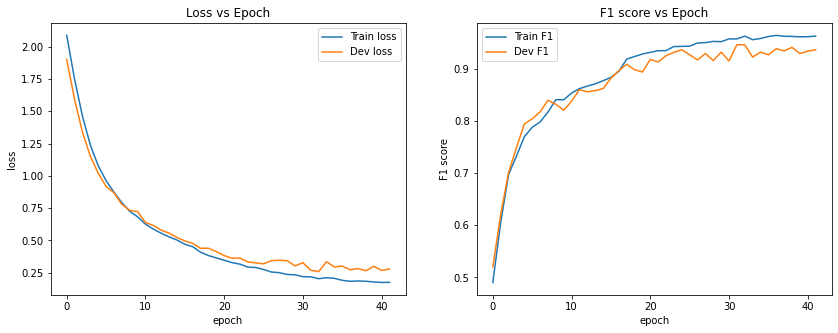

In [ ]:
loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr)

## EVALUATION

Evaluation is done on the test set, reporting precision, recall and f1-score for all classes. The weighted f1-score is the main reported measure.\
The confusion measure is also presented.

In [ ]:
activity_names = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic_walking', \
                  'ascending_stairs', 'descending_stairs', 'vacuum_cleaning', 'ironing', 'rope_jumping']

In [ ]:
def evaluate(model, dl , caption, plot_cm , print_scores,  verbose=False , cm_perventage = True):
    
    if print_scores == True:
        print(caption,"\n")
        
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl, disable=(not verbose)):
            data, label = batch      
            # Send tensors to GPU
            data = data.to(device)
            label = label.to(device)  
               
            pred = model(data)
            # Agg results
            pred_cls = np.argmax(pred.detach().to('cpu').numpy() , axis = 1)
            y_true.extend(label.detach().to('cpu').numpy().tolist())
            y_pred.extend(pred_cls) 
    
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    
    classes = np.union1d(y_true_arr, y_pred_arr)
    # tick_names = activity_names
    tick_names = [activity_names[c] for c in classes]
    ## Confusion Matrix - Multi class ## 
    if plot_cm == True:
        cnf_matrix = metrics.confusion_matrix(y_true_arr, y_pred_arr)
        if cm_perventage == True:
            cnf_matrix = cnf_matrix / cnf_matrix.sum(axis=1).reshape(-1,1)
            cnf_matrix = np.around(cnf_matrix, 2)
        fig, ax = plt.subplots(figsize=(16, 8))
        tick_marks = np.arange(len(tick_names))
        # print(cnf_matrix.shape, len(tick_names))

        if cm_perventage == True:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), \
                        annot=True, cmap="Blues",fmt='g' , vmin = 0 , vmax = 1)
        else:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), annot=True, cmap="YlGnBu",fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion Matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
    # Scores #
    f1_s = f1_score(y_true_arr, y_pred_arr, sample_weight=None, average  = 'weighted', zero_division='warn')
    m1 = metrics.classification_report(y_true_arr, y_pred_arr, target_names = tick_names, output_dict=True, digits=3, zero_division = 0)
    
    f1_all = m1['weighted avg']['f1-score']
        
    if print_scores == True:
        print(metrics.classification_report(y_true_arr, y_pred_arr, target_names = tick_names,digits=3, zero_division = 0  ))
        print(f1_s)
    
    return f1_s

Classifier results 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


                   precision    recall  f1-score   support

            lying      0.984     1.000     0.992        61
          sitting      0.806     0.967     0.879        60
         standing      0.830     0.609     0.703        64
          walking      1.000     0.956     0.977        68
          running      0.981     0.898     0.938        59
          cycling      1.000     0.963     0.981        54
   Nordic_walking      0.972     1.000     0.986        70
 ascending_stairs      0.938     0.909     0.923        33
descending_stairs      0.800     0.889     0.842        27
  vacuum_cleaning      0.927     0.927     0.927        55
          ironing      0.875     0.919     0.897        99
     rope_jumping      0.000     0.000     0.000         0

         accuracy                          0.914       650
        macro avg      0.843     0.836     0.837       650
     weighted avg      0.922     0.914     0.915       650

0.9153351180565593


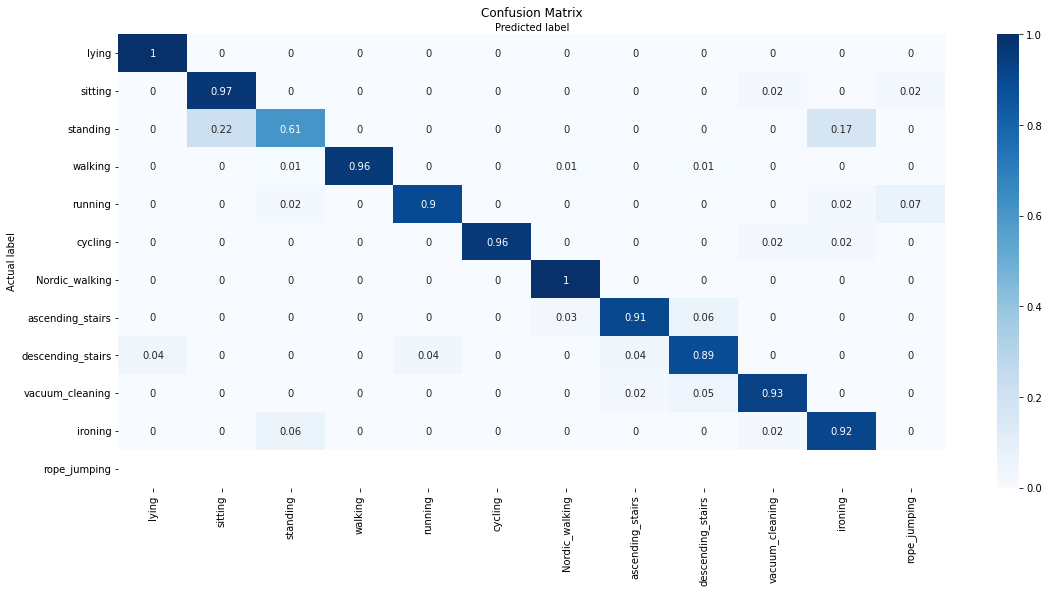

In [ ]:
f1_s_model_cls  = evaluate(model = model, dl = dl_test, caption = "Classifier results" ,\
                                               plot_cm = True, print_scores = True)

In [ ]:
base_model_results = np.array([0.9, 0.9, 0.888, 0.888, 0.864, 0.892, 0.87, 0.92, 0.877, 0.852, 0.917, 0.878, 0.922, 0.891, 0.856, 0.92, 0.928, 0.9252, 0.855, 0.915, 0.885, 0.857, 0.925, 0.892, 0.829, 0.924, 0.902, 0.837, 0.932])
print('Mean f1-score for base model is ', np.mean(base_model_results))
print('f1-score std for base model is ', np.std(base_model_results))

Mean f1-score for base model is  0.8910758620689655
f1-score std for base model is  0.028882325524533414


After running dozens of tests with our base model, we can report that the mean f1-score without augmentation is **0.891** with std of **0.029**

# Experiments with model architecture and parameters

We did the following experiments:
* Compare between augmented and non-augmented data
* Run a test without FFT
* Change the window size ( = time-steps sequence length)
* Compare GRU hidden state sizes
* Run classic ML algorithms on pre-processed data
* Evaluate on different subjects as test dataset (not subject 106)
* Run model with and without attention

### Some helper functions...

In [ ]:
def bar_plot(f1_s_dict , title):

    f1_s_dict_sorted = dict(sorted(f1_s_dict.items(), key=lambda item: item[1]))

    figsize=(10,6)
    plt.rcParams.update({'font.size': 16})
    size = range(len(f1_s_dict_sorted))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, f1_s_dict_sorted.values(), color=plt.cm.Paired(size))
    ax.set_xticklabels(f1_s_dict_sorted.keys(),rotation=45)
    ax.set_xticks(np.arange(len(f1_s_dict_sorted)))

    ax.set_title(title)

    for p in ax.patches:
        ax.annotate(str( int(p.get_height()*1000 )/1000 ), (p.get_x() * 1.010, p.get_height() * 1.010))


In [ ]:
def load_data (test_sub_num):
    
    print ("\n\nsubject_test_num: {}".format(test_sub_num))
    # load file 
    path = './train_dev_test_aug1_n20_sub_{}'.format(test_sub_num)
    with open(path , 'rb') as f:
        (train, dev, test) = pickle.load(f)
        
    # data loader 
    batch_size = 64
    dl_train = DataLoader(train, batch_size=batch_size, shuffle=True)
    dl_dev = DataLoader(dev, batch_size=batch_size)
    dl_test = DataLoader(test, batch_size=batch_size)

    return dl_train, dl_dev, dl_test


def load_and_train (test_sub_num):
    
    dl_train , dl_dev , dl_test = load_data(test_sub_num)
    
    # Model
    model = AttnSense(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50 , AG = True , AF = True , num_classes = len(activity_names) ).to(device)
    lr = 1e-4
    optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 
    
    # train
    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
    train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
               device = device , early_stopping = 10,verbose=False)
    
    #eval
    f1_s_model_cls  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                               plot_cm = True , print_scores = True)
    
    return  f1_s_model_cls
    

## Augmentation
We report differences in f1-score results with and without augmentation.
Augmented data was of factor 5 - meaning 4 additional copies with added noise.\
We experimented with noise at a scale of 20% of original std (for each sensor), 40% and 200%.\
In general the learning process gets less stable.\
With noise at 200%, f1-score was degraded to 0.74, so this was not repeated. 40% and 20% were repeated with average f1-scores of 0.903 and 0.911 accordingly.\
The learning curves are much less smooth.

Due to the long time it takes to run each augmented set (~5 hours on Tesla P100 GPU), we did our comparison of parameters on non-augmented data.

In [ ]:
# 5 results with augmentation 20%:
aug_results = np.array([0.91, 0.904, 0.9469, 0.897, 0.898])
print('Mean f1-score with data augmentation 20% is ', np.mean(aug_results))
print('f1-score std with data augmentation 20% is ', np.std(aug_results))

# 3 results with augmentation 40%:
aug_results = np.array([0.93, 0.93, 0.85]) #! strange results, but that's what it is
print('Mean f1-score with data augmentation 40% is ', np.mean(aug_results))
print('f1-score std with data augmentation 40% is ', np.std(aug_results))

Mean f1-score with data augmentation 20% is  0.9111799999999999
f1-score std with data augmentation 20% is  0.018458862370146194
Mean f1-score with data augmentation 40% is  0.9033333333333333
f1-score std with data augmentation 40% is  0.03771236166328257


We conclude that adding augmentation may improve results, but still very close to the margine of error. The rest of the experiments were done without augmentation to save precious time.

## No FFT

We checked the contribution of the FFT. With this stage removed, each time-step is back to being 25 points long. The average f1-score for 5 runs without FFT was **0.857**. This is lower than the basic model although we expected a bigger difference. In addition to the score difference, it was also noted that this model took longer to run per epoch due to the data dimensionality. We conclude that FFT is a useful operation.

In [ ]:
# 5 results without FFT:
no_fft_results = np.array([0.897, 0.848, 0.8479, 0.82, 0.873])
print('Mean f1-score without FFT is ', np.mean(no_fft_results))
print('f1-score std without FFT is ', np.std(no_fft_results))

Mean f1-score without FFT is  0.8571799999999999
f1-score std without FFT is  0.026033240290059958


## Window size N

The sequence size N can greatly influence the prediction accuracy. On one hand, N needs to be long enough to contain enough data for a good prediction. On the other hand, you can expect less long coherent samples from random data.\
With each dataset of different N, we ran training and evaluation 5 time.\
The results are summarized below.


In [ ]:
N5_results = np.array([0.802, 0.835, 0.863, 0.844, 0.783])
N10_results = np.array([0.8994, 0.805, 0.876, 0.8998, 0.8856])
N20_results = np.array([0.9, 0.9, 0.888, 0.888, 0.864, 0.892, 0.87, 0.92, 0.877, 0.852, 0.917, 0.878, 0.922, 0.891, 0.856, 0.92, 0.928, 0.9252, 0.855, 0.915, 0.885, 0.857, 0.925, 0.892, 0.829, 0.924, 0.902, 0.837, 0.932])
N30_results = np.array([0.803, 0.8807, 0.934, 0.903, 0.923])
N_means = [np.mean(N5_results), np.mean(N10_results), np.mean(N20_results), np.mean(N30_results)]

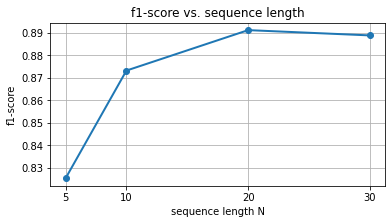

In [ ]:
plt.figure(figsize=(6,3))
plt.plot([5, 10, 20, 30], N_means, 'o-', linewidth=2)
plt.xticks([5, 10, 20, 30])
plt.xlabel('sequence length N')
plt.ylabel('f1-score')
plt.title('f1-score vs. sequence length')
plt.grid(visible = True)
plt.show()

Results are slightly different from those of the paper (all are better), but the conclusion is the same.

## 1 vs 4 convolution layers

For running with 1 convolution layer for CNN, the results show a lower mean (0.87) and a higher variance (0.05) of the results (although running is faster on average)

In [ ]:
# 5 results for running with 1 convolution layer
conv1_results = np.array([0.7668, 0.902, 0.922, 0.88, 0.894])
print('Mean f1-score with 1 conv layer is ', np.mean(conv1_results))
print('f1-score std with 1 conv layer is ', np.std(conv1_results))

Mean f1-score with 1 conv layer is  0.87296
f1-score std with 1 conv layer is  0.05479129857924522


## Different hidden size

The paper does not state the GRU hidden size used.\
Therefore, we have explored a few relevant values for this architecture parameter: (15 , 25 , 50 , 100).\
We expect the hidden size to be in the range of a few  input sizes. The input size is 13 (25 timestamps represented by 13 values after FFT).\
All results reported used GRU hidden size = 50, which are confirmed to be a reasonable working point. 

In [ ]:
hidden_size_list = [15, 25, 50, 100]

In [ ]:
%%time
dl_train, dl_dev, dl_test = load_data(106) 
# To run on subject 106 usual split use this:
# path = './train_dev_test_aug1_n20'
# with open(path, 'rb') as f:
#     (train, dev, test) = pickle.load(f)

for hidden_size in hidden_size_list:
    print ("\n\nHidden size ", hidden_size)
    model = AttnSense(num_features = X.shape[2], input_size = X.shape[3], num_conv_layer = 4  \
                  , hidden_size = hidden_size, AG = True, AF = True, num_classes = len(activity_names) ).to(device)

    lr = 1e-4
    optimizer = Adam(model.parameters(), lr=lr, weight_decay = 1e-4) 
    
    loss_train_arr, loss_dev_arr, acc_train_arr, acc_dev_arr, f1_train_arr, f1_dev_arr = \
    train_loop(model = model, optimizer = optimizer, n_epochs=100, dl_train = dl_train, dl_dev = dl_dev, \
               device = device, early_stopping = 10, verbose=True)
    
    f1_s_model_cls = evaluate(model = model, dl = dl_test, caption = "Classifier results",\
                        plot_cm = True, print_scores = True)

In [ ]:
hidden_size_df = pd.DataFrame(columns = hidden_size_list)

hidden_size_df = hidden_size_df.append(pd.DataFrame([ [0.89, 0.84, 0.89, 0.907] ], columns = hidden_size_list),ignore_index = True)
hidden_size_df = hidden_size_df.append(pd.DataFrame([ [0.885, 0.878, 0.89, 0.907] ], columns = hidden_size_list),ignore_index = True)
hidden_size_df = hidden_size_df.append(pd.DataFrame([ [0.817, 0.864, 0.89, 0.907] ], columns = hidden_size_list),ignore_index = True)
hidden_size_df = hidden_size_df.append(pd.DataFrame([ [0.905, 0.911, 0.89, 0.907] ], columns = hidden_size_list),ignore_index = True)
#two last point are averaged on more than 4 point.... so the mean is used
hidden_size_df = hidden_size_df.mean(axis = 0)

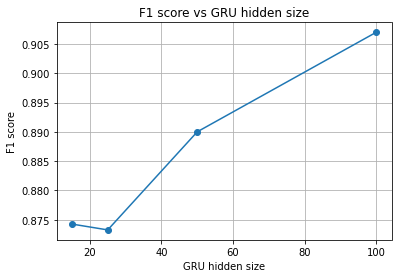

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))  
axes.set_xlabel('GRU hidden size')
axes.set_ylabel('F1 score')
axes.set_title('F1 score vs GRU hidden size')
axes.plot(hidden_size_list, hidden_size_df, marker = "o")
plt.grid(visible = True)

## Different subjects as tests

The paper keeps all samples of one subject (106) as a test. This makes sense, since real evaluation will probably be done on an unknown subject. However, the paper does not state why this subject was chosen and doesn't report results for other subjects. We think it makes more sense to report at least an average f1-score over different test subjects. Therefore, we thought it would be interesting to test the model over all subjects. Below are the results for different test subjects.

Our conclusion is that 106 achieves the highest score, but that variance is great. For example, if we chose to use subject 101, it's f1-score would be around 0.69 (far below 3 std-distance from results for 106)



subject_test_num: 102

Epoch 1
Train loss  : 2.320,   Dev loss    : 2.134
Train acc  : 0.339,   Dev acc    : 0.526
Train f1    : 0.270,   Dev f1    : 0.437

Epoch 6
Train loss  : 1.102,   Dev loss    : 1.013
Train acc  : 0.694,   Dev acc    : 0.721
Train f1    : 0.628,   Dev f1    : 0.656

Epoch 11
Train loss  : 0.800,   Dev loss    : 0.809
Train acc  : 0.732,   Dev acc    : 0.733
Train f1    : 0.683,   Dev f1    : 0.697

Epoch 16
Train loss  : 0.580,   Dev loss    : 0.516
Train acc  : 0.854,   Dev acc    : 0.881
Train f1    : 0.841,   Dev f1    : 0.868

Epoch 21
Train loss  : 0.408,   Dev loss    : 0.391
Train acc  : 0.929,   Dev acc    : 0.924
Train f1    : 0.928,   Dev f1    : 0.922

Epoch 26
Train loss  : 0.314,   Dev loss    : 0.275
Train acc  : 0.946,   Dev acc    : 0.938
Train f1    : 0.946,   Dev f1    : 0.939

Epoch 31
Train loss  : 0.241,   Dev loss    : 0.216
Train acc  : 0.953,   Dev acc    : 0.957
Train f1    : 0.953,   Dev f1    : 0.957

Epoch 36
Train loss  : 0.213,   

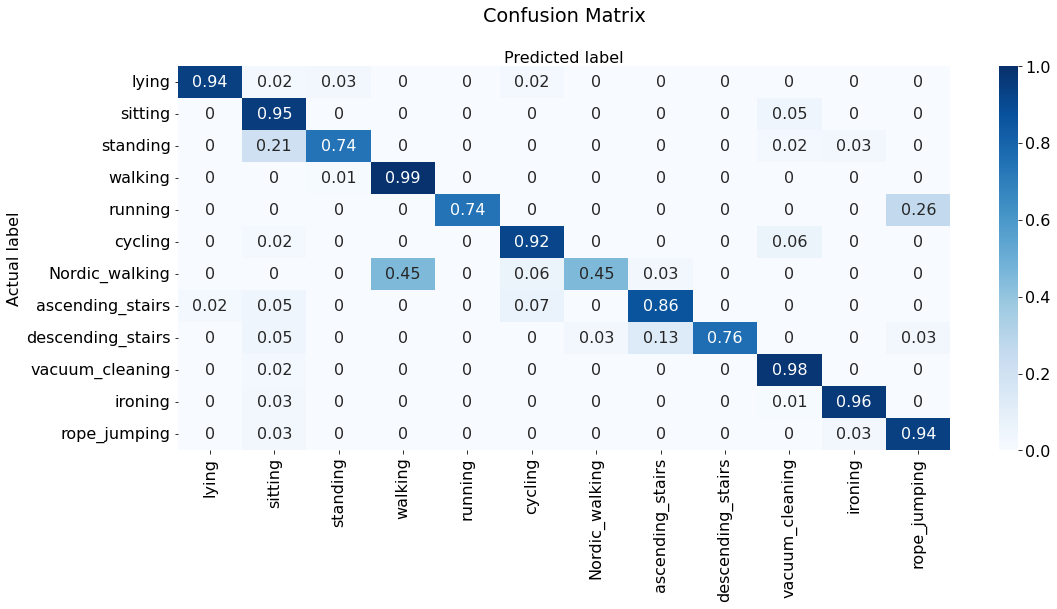

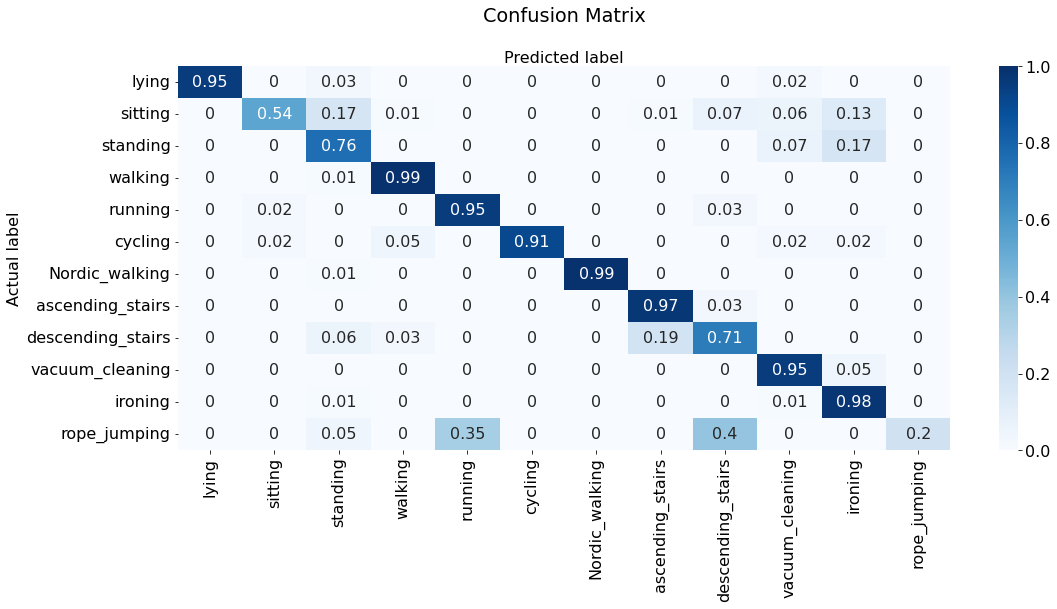

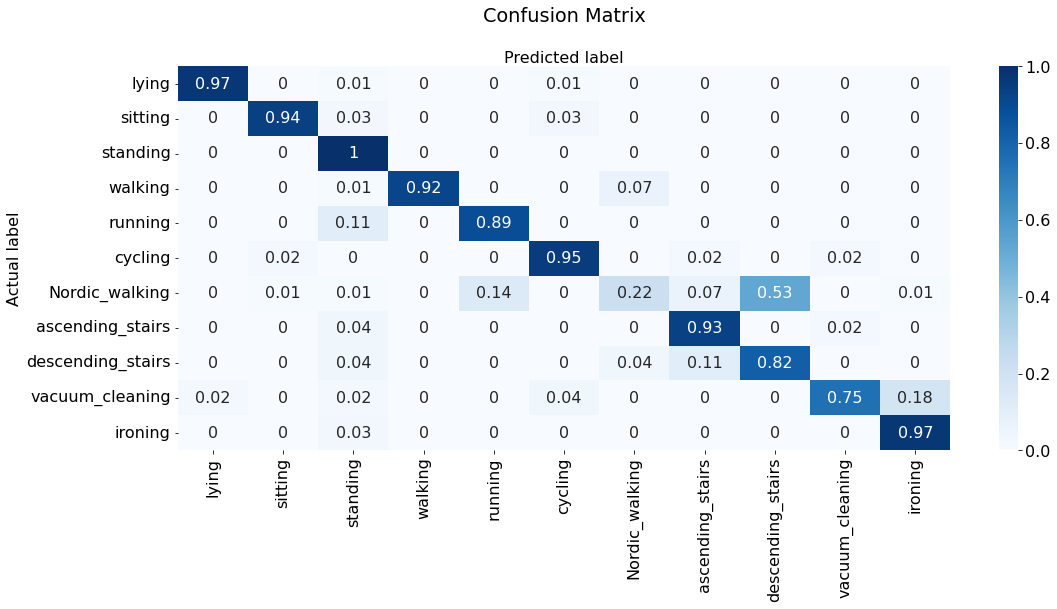

In [ ]:
%%time
f1_s_dict_2 = {}
test_subjects_list = [102 , 105 , 107]

for test_sub_num in test_subjects_list:
    f1_s_dict_2[test_sub_num] = load_and_train(test_sub_num)
   

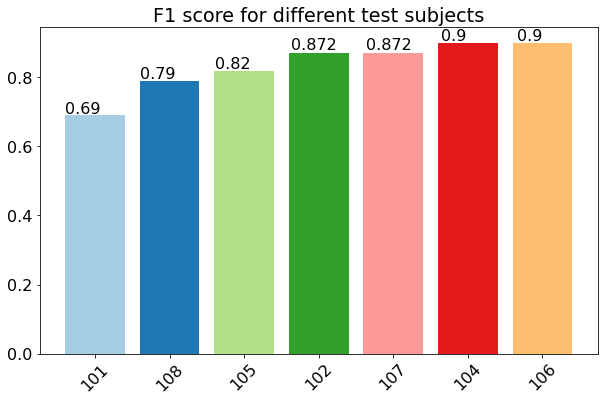

In [ ]:
f1_s_dict = {}
f1_s_dict[101] = 0.69 
f1_s_dict[102] = 0.872   # 0.827  , 0.928 0.898 0.856 0.849
f1_s_dict[104] = 0.9 
f1_s_dict[105] = 0.82   # 0.865 0.762 0.87 0.751 0.863
f1_s_dict[106] = 0.9  
f1_s_dict[107] = 0.872   # 0.832 , 0.948 0 .84 0.913 0.827
f1_s_dict[108] = 0.79 

bar_plot(f1_s_dict , title = "F1 score for different test subjects")

## Classic ML algorithms

The paper presented base results for Random Forest (RF) and SVM.\
We assume these algorithms were applied to raw samples - meaning that each sample is a single point in time with readings from all sensors.\
We wanted to test performance of classic algorithms when applied to the equivalent of our samples.\
We then took all the data of a single processed sample, containing all sensors after FFT, and all time-steps within a window, and flattened them as new inputs.\
We applied the scikit-learn tools on this data.\
The results was completely surprising. **RF achieved better results than AttnSense** for subject 106. Results were comparable or better on the majority of the other subject. The obvious plus is that RF takes less than a minute to run.

Below is the results summary followed by the code and execution.


## W and w/o Attention - AF Concatenation

We achieved similar results to the paper when applying attention only on sensors data. We did not observe score reduction when avoided temporal attention like reported in the paper.

In [ ]:
# load data with subject 106 as test
test_sub_num = 106
dl_train , dl_dev , dl_test = load_data(test_sub_num)
lr = 1e-4

dl_iter = iter(dl_train)
batch = next(dl_iter)
batch[0].shape

X = torch.tensor(batch[0],dtype=torch.float32).to(device) 



 AF_False_AG_False

Epoch 1
Train loss  : 2.085,   Dev loss    : 1.835
Train acc  : 0.541,   Dev acc    : 0.637
Train f1    : 0.480,   Dev f1    : 0.574

Epoch 6
Train loss  : 0.838,   Dev loss    : 0.811
Train acc  : 0.929,   Dev acc    : 0.917
Train f1    : 0.928,   Dev f1    : 0.916

Epoch 11
Train loss  : 0.420,   Dev loss    : 0.411
Train acc  : 0.960,   Dev acc    : 0.953
Train f1    : 0.960,   Dev f1    : 0.953

Epoch 16
Train loss  : 0.254,   Dev loss    : 0.331
Train acc  : 0.971,   Dev acc    : 0.953
Train f1    : 0.971,   Dev f1    : 0.953

Epoch 21
Train loss  : 0.168,   Dev loss    : 0.181
Train acc  : 0.976,   Dev acc    : 0.963
Train f1    : 0.977,   Dev f1    : 0.963

Epoch 26
Train loss  : 0.120,   Dev loss    : 0.181
Train acc  : 0.982,   Dev acc    : 0.955
Train f1    : 0.982,   Dev f1    : 0.955

Epoch 31
Train loss  : 0.089,   Dev loss    : 0.130
Train acc  : 0.988,   Dev acc    : 0.973
Train f1    : 0.988,   Dev f1    : 0.972

Epoch 36
Train loss  : 0.067,   Dev


Epoch 26
Train loss  : 0.272,   Dev loss    : 0.396
Train acc  : 0.947,   Dev acc    : 0.915
Train f1    : 0.947,   Dev f1    : 0.915

Epoch 31
Train loss  : 0.227,   Dev loss    : 0.318
Train acc  : 0.955,   Dev acc    : 0.927
Train f1    : 0.956,   Dev f1    : 0.928

Epoch 36
Train loss  : 0.194,   Dev loss    : 0.266
Train acc  : 0.960,   Dev acc    : 0.935
Train f1    : 0.961,   Dev f1    : 0.935

Epoch 41
Train loss  : 0.177,   Dev loss    : 0.232
Train acc  : 0.963,   Dev acc    : 0.948
Train f1    : 0.963,   Dev f1    : 0.948

Epoch 46
Train loss  : 0.150,   Dev loss    : 0.223
Train acc  : 0.969,   Dev acc    : 0.940
Train f1    : 0.969,   Dev f1    : 0.940

Epoch 51
Train loss  : 0.125,   Dev loss    : 0.311
Train acc  : 0.975,   Dev acc    : 0.943
Train f1    : 0.975,   Dev f1    : 0.943
Classifier results 

(11, 11) 11
                   precision    recall  f1-score   support

            lying      0.953     1.000     0.976        61
          sitting      0.810     0.850

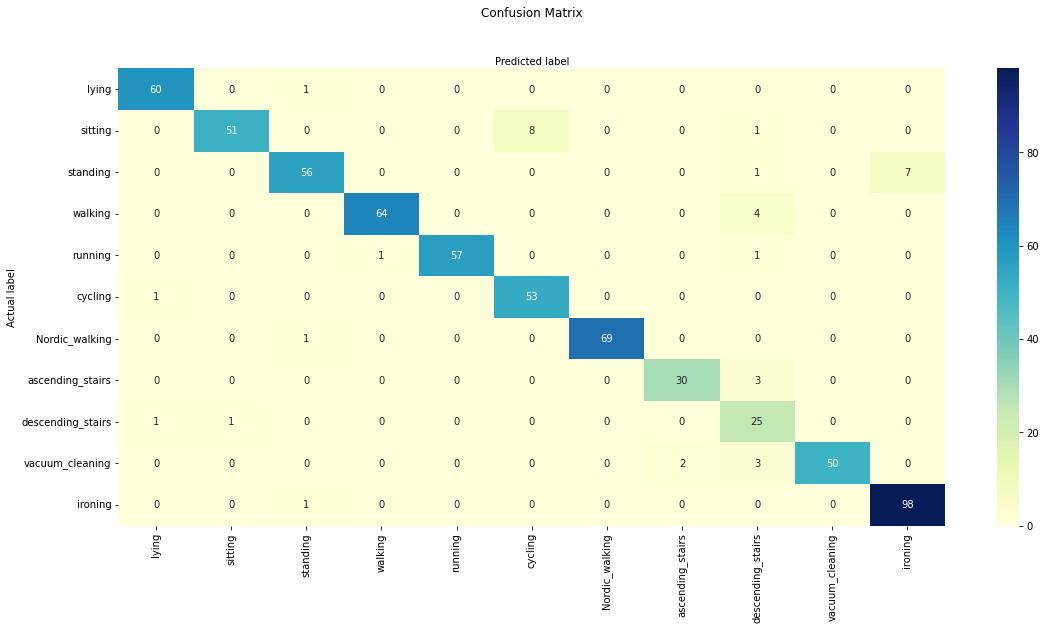

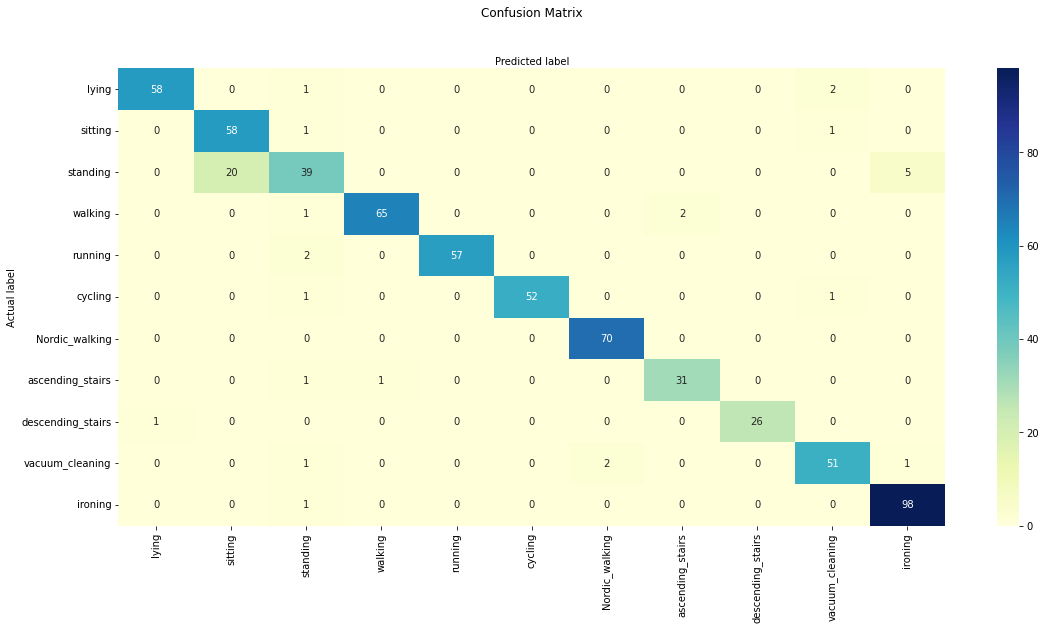

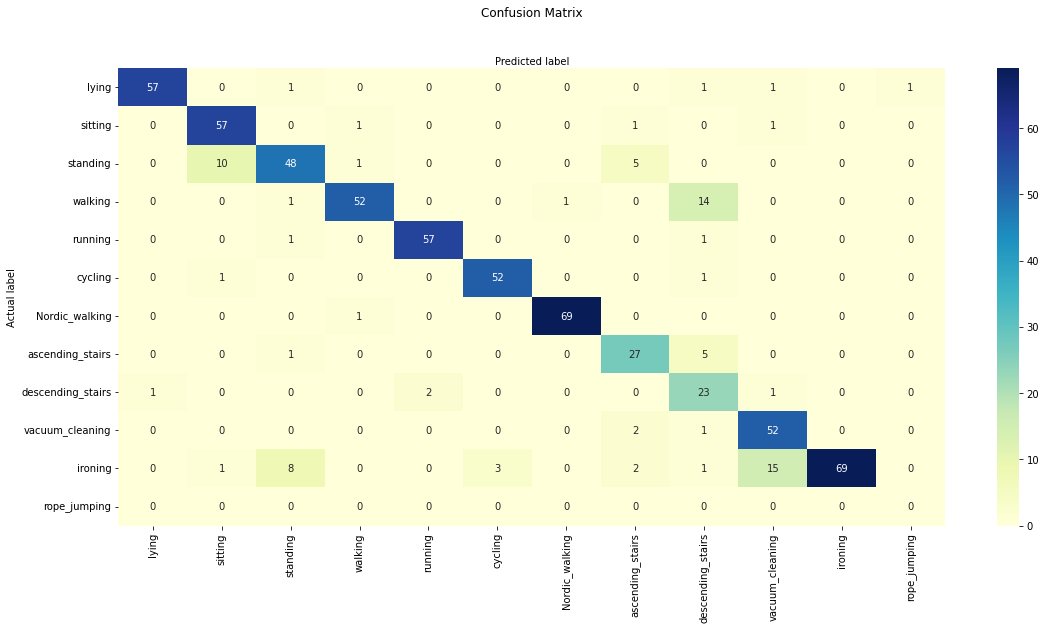

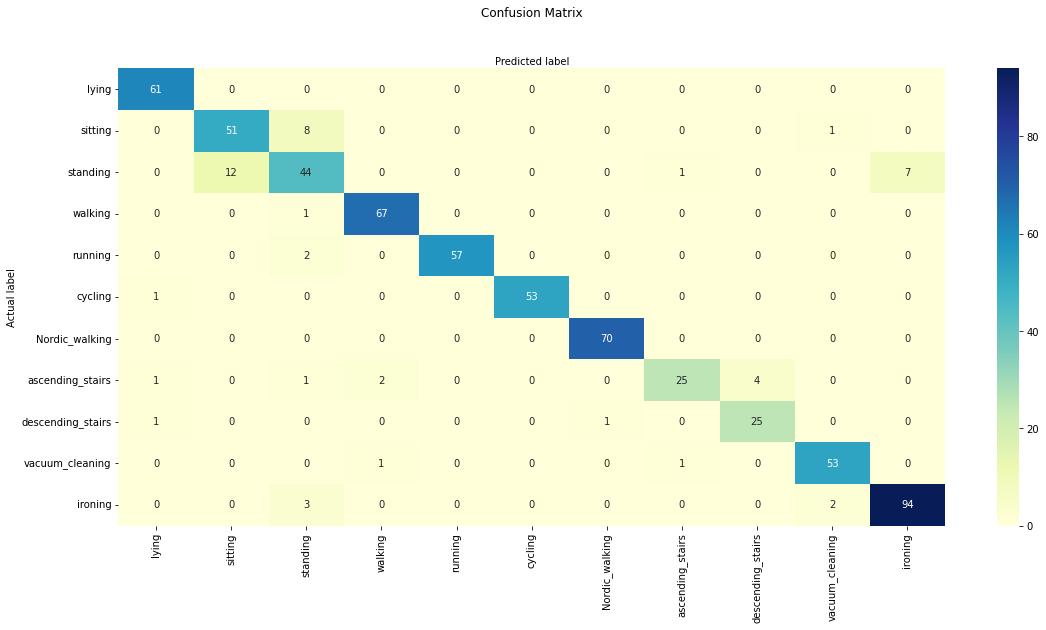

In [ ]:
%%time

f1_s_att_dict = {}

for AF in [False , True]:
    for AG in [False , True]:
    
        k = 'AF_{}_AG_{}'.format(AF,AG)
        print ("\n\n",k)
        model = AttnSense(num_features = X.shape[2], input_size = X.shape[3], num_conv_layer = 4  \
                  , hidden_size = 50 , AG = AG , AF = AF , num_classes = len(activity_names) ).to(device)
    
        optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 
    
        # train
        loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
               device = device , early_stopping = 10,verbose=False)
    
        #eval
        f1_s_att_dict[k]  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                                   plot_cm = True , print_scores = True)

<ipython-input-18-511550369b1c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f1_s_dict_sorted.keys(),rotation=45)


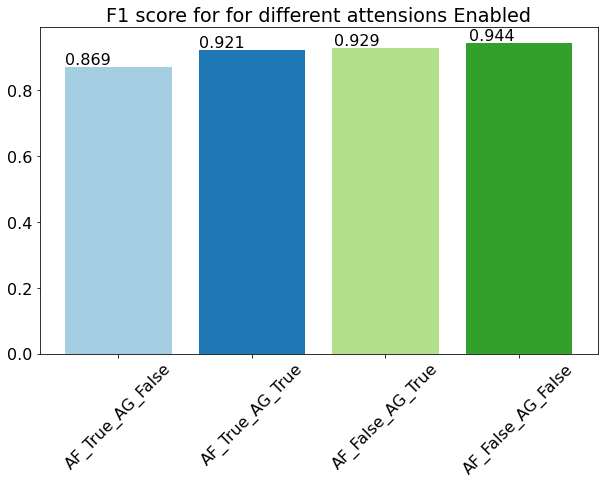

In [ ]:
bar_plot(f1_s_att_dict , title = "F1 score for for different attensions Enabled")


## W and w/o Attensions - AF Mean

In [ ]:
# load data with subject 106 as test
test_sub_num = 106
dl_train , dl_dev , dl_test = load_data(test_sub_num)
lr = 1e-4

dl_iter = iter(dl_train)
batch = next(dl_iter)
batch[0].shape

X = torch.tensor(batch[0],dtype=torch.float32).to(device) 



subject_test_num: 106




 AF_False_AG_False

Epoch 1
Train loss  : 2.451,   Dev loss    : 2.399
Train acc  : 0.122,   Dev acc    : 0.110
Train f1    : 0.027,   Dev f1    : 0.025

Epoch 6
Train loss  : 1.424,   Dev loss    : 1.369
Train acc  : 0.519,   Dev acc    : 0.542
Train f1    : 0.399,   Dev f1    : 0.429

Epoch 11
Train loss  : 0.933,   Dev loss    : 0.916
Train acc  : 0.802,   Dev acc    : 0.772
Train f1    : 0.762,   Dev f1    : 0.745

Epoch 16
Train loss  : 0.599,   Dev loss    : 0.621
Train acc  : 0.879,   Dev acc    : 0.875
Train f1    : 0.848,   Dev f1    : 0.846

Epoch 21
Train loss  : 0.428,   Dev loss    : 0.483
Train acc  : 0.903,   Dev acc    : 0.897
Train f1    : 0.888,   Dev f1    : 0.884

Epoch 26
Train loss  : 0.332,   Dev loss    : 0.391
Train acc  : 0.943,   Dev acc    : 0.925
Train f1    : 0.941,   Dev f1    : 0.923

Epoch 31
Train loss  : 0.271,   Dev loss    : 0.339
Train acc  : 0.955,   Dev acc    : 0.938
Train f1    : 0.955,   Dev f1    : 0.937

Epoch 36
Train loss  : 0.232,   Dev


Epoch 16
Train loss  : 0.528,   Dev loss    : 0.551
Train acc  : 0.848,   Dev acc    : 0.850
Train f1    : 0.826,   Dev f1    : 0.831

Epoch 21
Train loss  : 0.456,   Dev loss    : 0.524
Train acc  : 0.858,   Dev acc    : 0.838
Train f1    : 0.841,   Dev f1    : 0.819

Epoch 26
Train loss  : 0.394,   Dev loss    : 0.419
Train acc  : 0.865,   Dev acc    : 0.865
Train f1    : 0.850,   Dev f1    : 0.854

Epoch 31
Train loss  : 0.358,   Dev loss    : 0.351
Train acc  : 0.881,   Dev acc    : 0.873
Train f1    : 0.871,   Dev f1    : 0.855

Epoch 36
Train loss  : 0.312,   Dev loss    : 0.331
Train acc  : 0.919,   Dev acc    : 0.930
Train f1    : 0.918,   Dev f1    : 0.931

Epoch 41
Train loss  : 0.240,   Dev loss    : 0.276
Train acc  : 0.947,   Dev acc    : 0.938
Train f1    : 0.947,   Dev f1    : 0.938

Epoch 46
Train loss  : 0.207,   Dev loss    : 0.329
Train acc  : 0.954,   Dev acc    : 0.890
Train f1    : 0.955,   Dev f1    : 0.888

Epoch 51
Train loss  : 0.189,   Dev loss    : 0.217
Tr

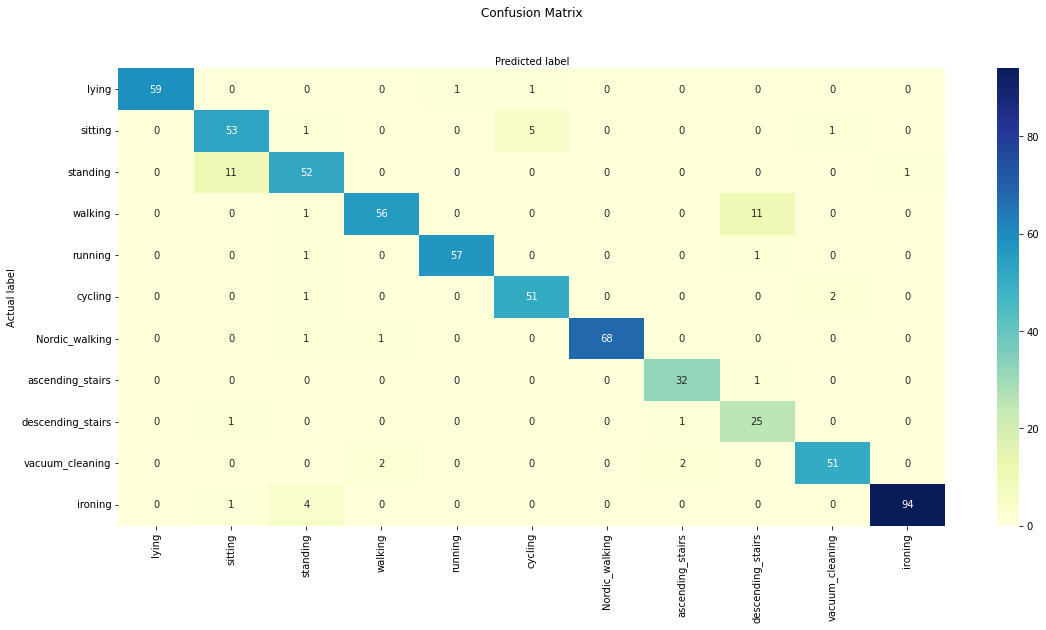

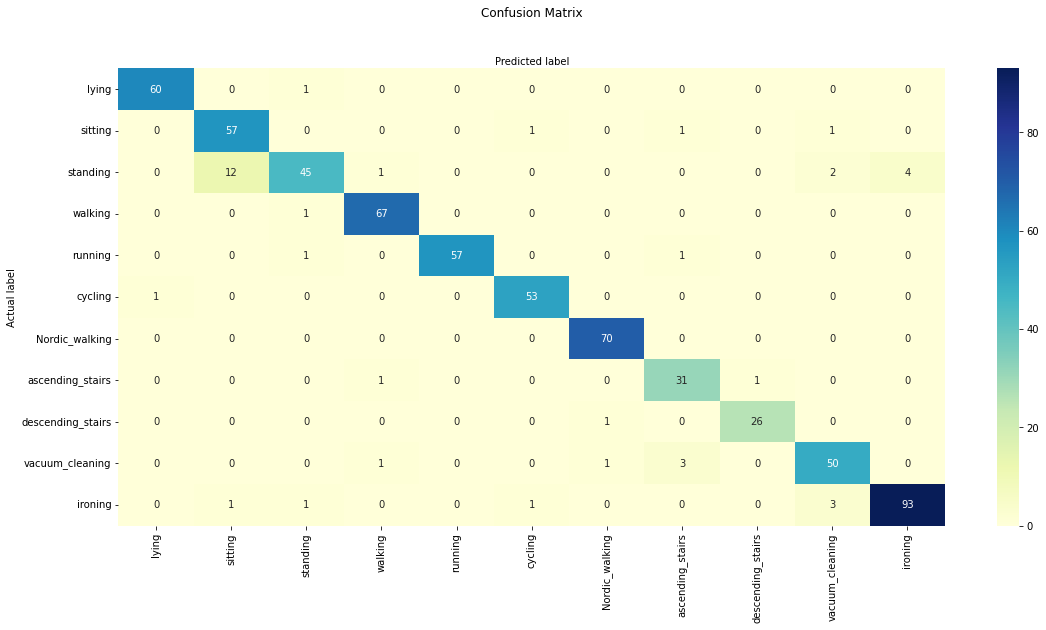

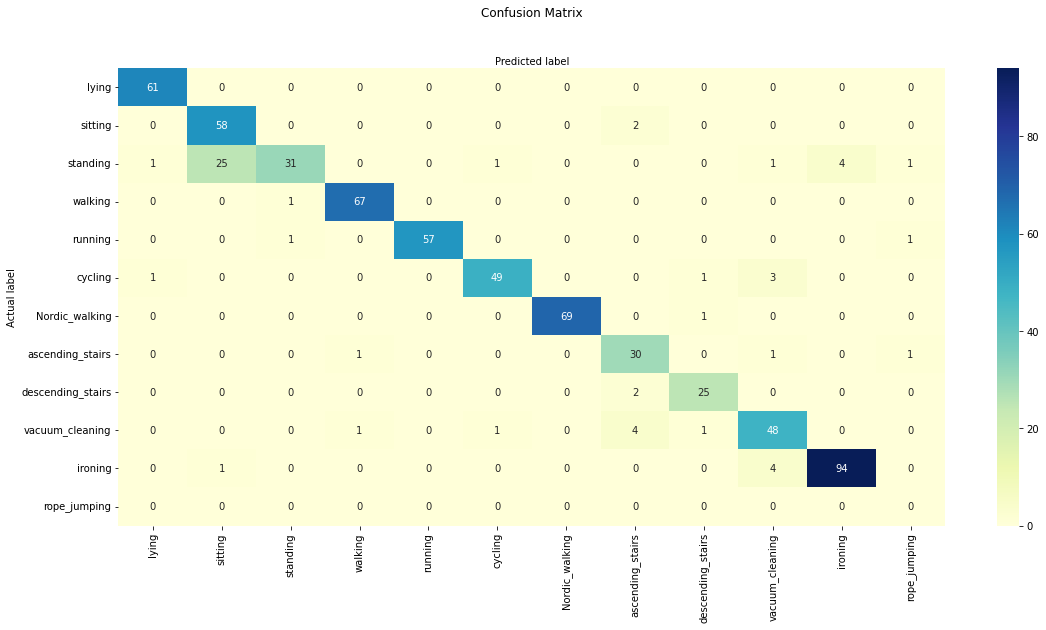

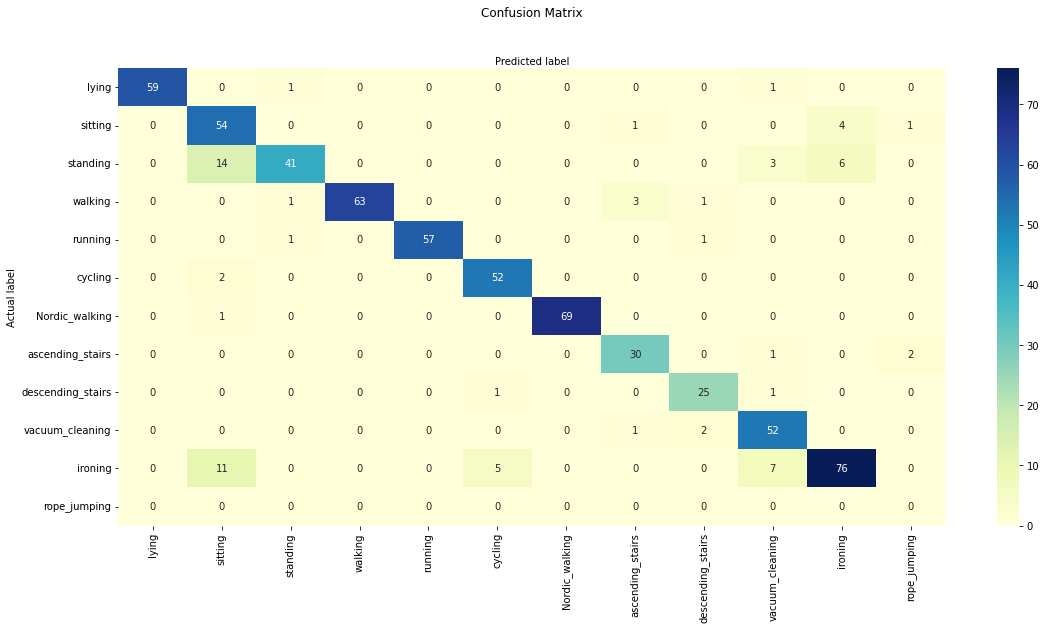

In [ ]:
%%time

f1_s_att_dict = {}

for AF in [False , True]:
    for AG in [False , True]:
    
        k = 'AF_{}_AG_{}'.format(AF,AG)
        print ("\n\n",k)
        model = AttnSense(num_features = X.shape[2], input_size = X.shape[3], num_conv_layer = 4  \
                  , hidden_size = 50 , AG = AG , AF = AF , num_classes = len(activity_names) ).to(device)
    
        optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 
    
        # train
        loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
               device = device , early_stopping = 10,verbose=False)
    
        #eval
        f1_s_att_dict[k]  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                                   plot_cm = True , print_scores = True)

In [ ]:
bar_plot(f1_s_att_dict , title = "F1 score for for different Attentions Enabled")

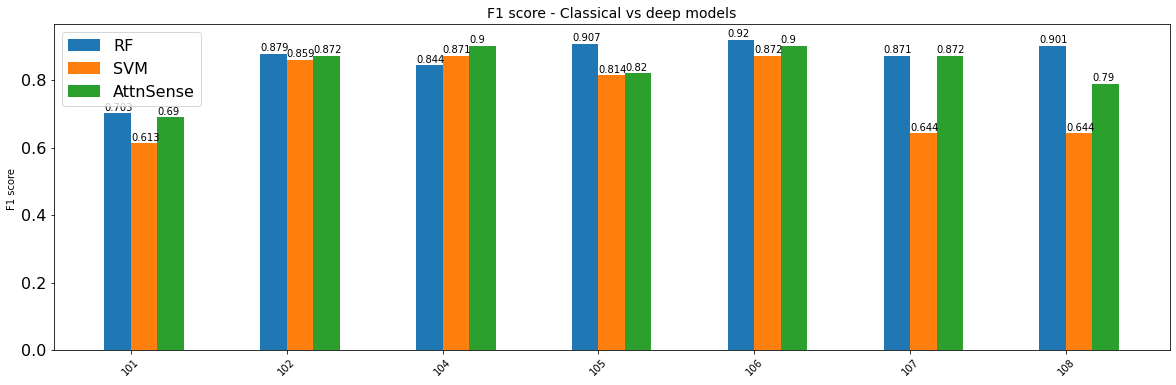

In [ ]:
labels = [101 , 102 , 104 , 105 , 106 , 107 , 108]
x = np.arange(len(labels))

rf = [0.703 , 0.879 , 0.844 , 0.907 , 0.92  , 0.871 ,  0.901]
svm = [0.613 , 0.859 , 0.871 , 0.814 , 0.872  , 0.644 ,0.644]
att = [0.69 , 0.872 , 0.9 , 0.82 , 0.9 , 0.872 , 0.79 ]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
width = 0.17
ax.bar(x - width/2, rf , width, label= "RF" )
ax.bar(x + width/2, svm , width, label="SVM")
ax.bar(x + width*3/2, att , width, label="AttnSense")

ax.set_title("F1 score - Classical vs deep models", fontsize=14)
ax.set_ylabel("F1 score ", fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(labels ,fontsize=10,rotation=45)
ax.legend()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.01), fontsize=10)

In [ ]:
def load_data_flat(test_sub_num):
    
    print ("\n\nsubject_test_num: {}".format(test_sub_num))
    # load file 
    path = './train_dev_test_aug1_n20_sub_{}'.format(test_sub_num)
    with open(path, 'rb') as f:
        (train, dev, test) = pickle.load(f)

    # To run on subject 106 usual split use this:
    # path = './train_dev_test_aug1_n20'
    # with open(path, 'rb') as f:
    #     (train, dev, test) = pickle.load(f)

    
    # stack and flatten all samples    
    X_train_seq = []
    y_train_seq = []
    X_dev_seq = []
    y_dev_seq = []
    X_test_seq = []
    y_test_seq = []

    for (X, y) in train:
      X_train_seq.append(X)
      y_train_seq.append(y)

    for (X, y) in dev:
      X_dev_seq.append(X)
      y_dev_seq.append(y)

    for (X, y) in test:
      X_test_seq.append(X)
      y_test_seq.append(y)

    X_train_seq  = torch.stack(X_train_seq , dim = 0)
    X_dev_seq = torch.stack(X_dev_seq , dim = 0)
    X_test_seq = torch.stack(X_test_seq , dim = 0)
    
    y_train_seq = torch.tensor(y_train_seq,dtype=torch.long)
    y_dev_seq = torch.tensor(y_dev_seq,dtype=torch.long)
    y_test_seq = torch.tensor(y_test_seq,dtype=torch.long)
    
    X_train = X_train_seq.numpy().reshape((X_train_seq.shape[0],-1))
    y_train = y_train_seq.numpy()

    X_dev = X_dev_seq.numpy().reshape((X_dev_seq.shape[0],-1))
    y_dev = y_dev_seq.numpy()
    
    X_test = X_test_seq.numpy().reshape((X_test_seq.shape[0],-1))
    y_test = y_test_seq.numpy()

    return X_train , y_train , X_dev , y_dev , X_test , y_test
        
def skl_train_and_eval(model , model_name , X_train , y_train , X_test , y_test ):
    print ("\nModel: {}".format(model_name))
    
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    print('Aaccuracy on train: ', accuracy_score(y_train,preds)*100)
    preds = model.predict(X_test)
    print('Accuracy on test: ', accuracy_score(y_test,preds)*100)

    f1_s   = f1_score(y_test, preds, sample_weight=None, average = 'macro', zero_division='warn')
    print ("Test: f1_score macro: {:.3f}".format(f1_s))

    f1_s   = f1_score(y_test, preds, sample_weight=None, average = 'weighted', zero_division='warn')
    print ("Test: f1_score weighted: {:.3f}".format(f1_s)) 
    
def skl_train_and_eval_all(test_sub_num):
    X_train , y_train , X_dev , y_dev , X_test , y_test = load_data_flat(test_sub_num)
    
    model = DecisionTreeClassifier(random_state=0)
    skl_train_and_eval(model , "Decison tree" , X_train , y_train , X_test , y_test)
    
    model = RandomForestClassifier(random_state=36)
    skl_train_and_eval(model , "Random forest" , X_train , y_train , X_test , y_test)
    
    model = LogisticRegression(random_state=0)
    skl_train_and_eval(model , "Logistic regression" , X_train , y_train , X_test , y_test)
    
    model = SVC()
    skl_train_and_eval(model , "SVM" , X_train , y_train , X_test , y_test)
    

In [ ]:
RF_results_for_106 = np.array([0.921, 0.924, 0.93, 0.918, 0.927])
print('Mean f1-score of RF on subject 106 is ', np.mean(RF_results_for_106))
print('f1-score std of RF on subject 106 is ', np.std(RF_results_for_106))

Mean f1-score of RF on subject 106 is  0.9240000000000002
f1-score std of RF on subject 106 is  0.004242640687119289


In [ ]:
skl_train_and_eval_all(102)



subject_test_num: 102

Model: Decison tree
Aaccuracy on train:  100.0
Accuracy on test:  56.38766519823789
Test: f1_score macro: 0.510
Test: f1_score weighted: 0.538

Model: Random forest
Aaccuracy on train:  100.0
Accuracy on test:  88.98678414096916
Test: f1_score macro: 0.861
Test: f1_score weighted: 0.879

Model: Logistic regression


/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aaccuracy on train:  98.93373952779893
Accuracy on test:  79.58883994126285
Test: f1_score macro: 0.759
Test: f1_score weighted: 0.760

Model: SVM
Aaccuracy on train:  94.74485910129474
Accuracy on test:  86.63729809104258
Test: f1_score macro: 0.864
Test: f1_score weighted: 0.859


In [ ]:
skl_train_and_eval_all(104)



subject_test_num: 104

Model: Decison tree
Aaccuracy on train:  100.0
Accuracy on test:  58.9018302828619
Test: f1_score macro: 0.482
Test: f1_score weighted: 0.554

Model: Random forest
Aaccuracy on train:  100.0
Accuracy on test:  86.18968386023295
Test: f1_score macro: 0.835
Test: f1_score weighted: 0.844

Model: Logistic regression


/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aaccuracy on train:  98.775
Accuracy on test:  82.02995008319468
Test: f1_score macro: 0.726
Test: f1_score weighted: 0.804

Model: SVM
Aaccuracy on train:  94.75
Accuracy on test:  87.35440931780366
Test: f1_score macro: 0.871
Test: f1_score weighted: 0.871


In [ ]:
skl_train_and_eval_all(105)



subject_test_num: 105

Model: Decison tree
Aaccuracy on train:  100.0
Accuracy on test:  71.045197740113
Test: f1_score macro: 0.665
Test: f1_score weighted: 0.712

Model: Random forest
Aaccuracy on train:  100.0
Accuracy on test:  90.81920903954803
Test: f1_score macro: 0.897
Test: f1_score weighted: 0.907

Model: Logistic regression


/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aaccuracy on train:  98.8985655737705
Accuracy on test:  85.16949152542372
Test: f1_score macro: 0.839
Test: f1_score weighted: 0.851

Model: SVM
Aaccuracy on train:  95.41495901639344
Accuracy on test:  82.48587570621469
Test: f1_score macro: 0.818
Test: f1_score weighted: 0.814


In [ ]:
skl_train_and_eval_all(107)



subject_test_num: 107

Model: Decison tree
Aaccuracy on train:  100.0
Accuracy on test:  81.32231404958678
Test: f1_score macro: 0.711
Test: f1_score weighted: 0.808

Model: Random forest
Aaccuracy on train:  100.0
Accuracy on test:  88.92561983471074
Test: f1_score macro: 0.859
Test: f1_score weighted: 0.871

Model: Logistic regression


/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aaccuracy on train:  98.691165366222
Accuracy on test:  92.39669421487604
Test: f1_score macro: 0.823
Test: f1_score weighted: 0.924

Model: SVM
Aaccuracy on train:  95.01636043292223
Accuracy on test:  93.05785123966942
Test: f1_score macro: 0.916
Test: f1_score weighted: 0.929


In [ ]:
skl_train_and_eval_all(108)



subject_test_num: 108

Model: Decison tree
Aaccuracy on train:  100.0
Accuracy on test:  66.12903225806451
Test: f1_score macro: 0.629
Test: f1_score weighted: 0.646

Model: Random forest
Aaccuracy on train:  100.0
Accuracy on test:  90.17595307917888
Test: f1_score macro: 0.896
Test: f1_score weighted: 0.901

Model: Logistic regression


/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aaccuracy on train:  98.85321100917432
Accuracy on test:  79.76539589442815
Test: f1_score macro: 0.775
Test: f1_score weighted: 0.769

Model: SVM
Aaccuracy on train:  95.13251783893986
Accuracy on test:  69.06158357771261
Test: f1_score macro: 0.655
Test: f1_score weighted: 0.644
